In [1]:
# ==================================
# セル 1: パッケージのインポートと定数設定
# ==================================
import os
import sys
import pickle
import re
import math
import time
import glob
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sudachipy import dictionary as sudachi_dictionary
from sudachipy import tokenizer as sudachi_tokenizer
import CaboCha
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import pykakasi
import Levenshtein
import gc

# --- パス設定 ---
INPUT_EXCEL_PATH = '/home/ubuntu/cabochaProject/input_clustering.xlsx'
JAPANESE_WORD_LIST_PATH = '/home/ubuntu/cabochaProject/japanese_word_list2.txt'
NGRAM_DATA_BASE_PATH = '/home/ubuntu/cabochaProject/nwc2010-ngrams/word/over9'
PICKLE_CHUNK_DIR = '/home/ubuntu/cabochaProject/pickle_chunks'

# --- 出力設定 ---
OUTPUT_EXCEL_PATH = '/home/ubuntu/cabochaProject/4clustering_results.xlsx'
OUTPUT_GRAPH_PATH = '/home/ubuntu/cabochaProject/4clustering_visualization.png'
ARTIFACTS_OUTPUT_DIR = '/home/ubuntu/cabochaProject/clustering_artifacts'


# --- ハイパーパラメータ ---
HF_MODEL_NAME = "rinna/japanese-gpt2-xsmall"
EDIT_DISTANCE_THRESHOLD_LOG_PROB = -10.8799
WORD_3GRAM_THRESHOLD_LOG_PROB = -8.8
WORD_3GRAM_ALPHA = 0.001
CACHE_CLEAR_INTERVAL = 100
OPTIMAL_K = 6 # 事前分析やエルボー法などから決定したクラスタ数

print("定数設定完了。")

/home/ubuntu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


定数設定完了。


In [2]:
# ==============================
# セル 2: ライブラリの初期化
# ==============================
print("--- ライブラリ初期化開始 ---")

print("SudachiPy 初期化中...")
sudachi_tokenizer_dict_core = sudachi_dictionary.Dictionary(dict_type="core").create()
sudachi_dict_obj_core_for_lookup = sudachi_dictionary.Dictionary(dict_type="core")
sudachi_tokenizer_for_ngram = sudachi_dictionary.Dictionary(dict_type="core").create()
print("SudachiPy 初期化完了。")

print("CaboCha 初期化中...")
cabocha_parser = CaboCha.Parser()
print("CaboCha 初期化完了。")

print(f"Hugging Faceモデル {HF_MODEL_NAME} をロード中...")
hf_tokenizer_for_edit_dist = AutoTokenizer.from_pretrained(HF_MODEL_NAME)
hf_model_for_edit_dist = AutoModelForCausalLM.from_pretrained(HF_MODEL_NAME)
hf_model_for_edit_dist.eval()
if torch.cuda.is_available():
    hf_model_for_edit_dist.to(torch.device("cuda"))
    print("モデルをGPUにロードしました。")
else:
    print("モデルをCPUにロードしました。")

print("pykakasi 初期化中...")
kakasi_converter_for_edit_dist = pykakasi.kakasi()
kakasi_converter_for_edit_dist.setMode("K", "E")
kakasi_converter_for_edit_dist.setMode("r", "Hepburn")
print("pykakasi 初期化完了。")

print(f"編集距離用辞書データ '{JAPANESE_WORD_LIST_PATH}' をロード中...")
all_dictionary_data_for_edit_dist = []
with open(JAPANESE_WORD_LIST_PATH, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith('#'): continue
        parts = line.split('\t')
        if len(parts) >= 2 and parts[0] and parts[1]:
            all_dictionary_data_for_edit_dist.append((parts[0], parts[1]))
print(f"{len(all_dictionary_data_for_edit_dist)} 件ロードしました。")

print("--- ライブラリ初期化完了 ---")

--- ライブラリ初期化開始 ---
SudachiPy 初期化中...
SudachiPy 初期化完了。
CaboCha 初期化中...
CaboCha 初期化完了。
Hugging Faceモデル rinna/japanese-gpt2-xsmall をロード中...


/tmp/ipykernel_307697/1327240507.py:7: DeprecationWarning: Parameter dict_type of Dictionary() is deprecated, use dict instead
  sudachi_tokenizer_dict_core = sudachi_dictionary.Dictionary(dict_type="core").create()
/tmp/ipykernel_307697/1327240507.py:8: DeprecationWarning: Parameter dict_type of Dictionary() is deprecated, use dict instead
  sudachi_dict_obj_core_for_lookup = sudachi_dictionary.Dictionary(dict_type="core")
/tmp/ipykernel_307697/1327240507.py:9: DeprecationWarning: Parameter dict_type of Dictionary() is deprecated, use dict instead
  sudachi_tokenizer_for_ngram = sudachi_dictionary.Dictionary(dict_type="core").create()
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly 

モデルをGPUにロードしました。
pykakasi 初期化中...
pykakasi 初期化完了。
編集距離用辞書データ '/home/ubuntu/cabochaProject/japanese_word_list2.txt' をロード中...
217451 件ロードしました。
--- ライブラリ初期化完了 ---


/tmp/ipykernel_307697/1327240507.py:28: DeprecationWarning: Call to deprecated method setMode. (Old API will be removed in v3.0.) -- Deprecated since version 2.1.
  kakasi_converter_for_edit_dist.setMode("K", "E")
/tmp/ipykernel_307697/1327240507.py:29: DeprecationWarning: Call to deprecated method setMode. (Old API will be removed in v3.0.) -- Deprecated since version 2.1.
  kakasi_converter_for_edit_dist.setMode("r", "Hepburn")


In [3]:
# ==================================
# セル 3: 特徴量計算関数の定義
# ==================================

def check_word_in_sudachi_dictionary_revised(word, dict_obj):
    """Sudachi辞書に単語が存在するかチェックする"""
    morphemes = dict_obj.lookup(word)
    return len(morphemes) > 0

def calculate_dict_feature(text, tokenizer_obj, dict_obj_for_lookup_func):
    """テキスト中の名詞がSudachi辞書に存在しない場合に1を返す"""
    if not text or not isinstance(text, str): return 1
    try:
        mode_b = sudachi_tokenizer.Tokenizer.SplitMode.B
        morphemes = tokenizer_obj.tokenize(text, mode_b)
        found_undefined_noun = False
        noun_count = 0
        for m in morphemes:
            pos = m.part_of_speech()
            if pos and pos[0] == '名詞':
                noun_count += 1
                base_form = m.normalized_form()
                if not check_word_in_sudachi_dictionary_revised(base_form, dict_obj_for_lookup_func):
                    found_undefined_noun = True
                    break
        if noun_count == 0: return 0
        del morphemes
        gc.collect()
        return 1 if found_undefined_noun else 0
    except Exception as e:
        print(f"辞書照合エラー: {e} - テキスト: {text[:50]}...")
        return 1

def calculate_cabocha_features(text, parser):
    """CaboChaを使い、Token依存距離の分散と係り受けスコアの分散を計算"""
    if not text or not isinstance(text, str): return 0.0, 0.0
    if parser is None: return 0.0, 0.0
    try:
        tree = parser.parse(text)
        chunks = [tree.chunk(i) for i in range(tree.chunk_size())]
        if not chunks:
            del tree
            return 0.0, 0.0
        
        token_to_chunk = [None] * tree.token_size()
        for ci, ch in enumerate(chunks):
            for ti in range(ch.token_pos, ch.token_pos + ch.token_size):
                if ti < len(token_to_chunk):
                    token_to_chunk[ti] = ci
        
        token_distances = []
        for ti in range(tree.token_size()):
            if ti >= len(token_to_chunk) or token_to_chunk[ti] is None: continue
            ci = token_to_chunk[ti]
            if ci >= len(chunks): continue
            head_ci = chunks[ci].link
            if head_ci != -1 and head_ci < len(chunks):
                head_token_pos = chunks[head_ci].token_pos
                token_distances.append(abs(ti - head_token_pos))
        
        var_td = np.var(token_distances) if token_distances else 0.0
        scores = [ch.score for ch in chunks if ch.score is not None]
        var_sc = np.var(scores) if scores else 0.0
        
        del tree, chunks, token_to_chunk, token_distances, scores
        gc.collect()
        return var_td, var_sc
    except Exception as e:
        print(f"CaboCha特徴量計算エラー: {e} - テキスト: {text[:50]}...")
        return 0.0, 0.0

def is_jukugo_for_edit_dist(word):
    """漢字2文字以上からなる熟語かどうかを判定"""
    return bool(re.match(r'^[\u4E00-\u9FFF]{2,}$', word))

def katakana_to_romaji_for_edit_dist(katakana_text, kakasi_cv):
    """カタカナをローマ字に変換"""
    if not katakana_text: return ""
    try:
        return "".join([item.get('hepburn', item.get('orig', '')) for item in kakasi_cv.convert(katakana_text)]).lower()
    except Exception: return "___romaji_error___"

def estimate_segment_reading_for_edit_dist(segment_kanji, dictionary_data):
    """辞書とのレーベンシュタイン距離が最小の単語の読みを推定"""
    min_dist = sys.maxsize
    est_reading = None
    if not dictionary_data: return None
    for kanji, reading in dictionary_data:
        if not kanji: continue
        dist = Levenshtein.distance(segment_kanji, kanji)
        if dist < min_dist:
            min_dist = dist
            est_reading = reading
            if min_dist == 0: break
    return est_reading

def find_kanji_candidates_by_distance_for_edit_dist(segment_kanji, dictionary_data, max_dist=2, jukugo_only=True):
    """レーベンシュタイン距離が閾値以下の漢字候補を検索"""
    candidates = []
    dict_to_search = dictionary_data
    if jukugo_only:
        jukugo_dict = [(k, r) for k, r in dictionary_data if is_jukugo_for_edit_dist(k)]
        if jukugo_dict: dict_to_search = jukugo_dict
    
    temp_candidates = []
    for kanji, reading in dict_to_search:
        if not kanji: continue
        dist = Levenshtein.distance(segment_kanji, kanji)
        if dist <= max_dist:
            temp_candidates.append({'kanji': kanji, 'reading': reading, 'dist': dist})
    
    seen_kanji = set()
    for cand_info in sorted(temp_candidates, key=lambda x: x['dist']):
        if cand_info['kanji'] not in seen_kanji:
            candidates.append((cand_info['kanji'], cand_info['reading'], cand_info['dist']))
            seen_kanji.add(cand_info['kanji'])
    del temp_candidates, seen_kanji, dict_to_search
    gc.collect()
    return candidates

def find_best_candidate_romaji_rerank_for_edit_dist(est_seg_reading_romaji, initial_candidates, kakasi_cv):
    """ローマ字の距離で候補を再ランキングし、最適な候補を見つける"""
    min_romaji_dist = sys.maxsize
    best_cand_kanji, best_kanji_dist_orig = None, sys.maxsize
    if est_seg_reading_romaji in ["", "___romaji_error___"] or not initial_candidates:
        return None, sys.maxsize
    for kanji, reading, kanji_dist in initial_candidates:
        cand_reading_romaji = katakana_to_romaji_for_edit_dist(reading, kakasi_cv)
        if cand_reading_romaji == "___romaji_error___": continue
        romaji_dist = Levenshtein.distance(est_seg_reading_romaji, cand_reading_romaji)
        if romaji_dist < min_romaji_dist:
            min_romaji_dist = romaji_dist
            best_cand_kanji = kanji
            best_kanji_dist_orig = kanji_dist
    if best_cand_kanji is None: return None, sys.maxsize
    return best_cand_kanji, best_kanji_dist_orig

def calculate_edit_distance_feature(text, tokenizer, model, dictionary_data, kakasi_cv, threshold_log_p):
    """GPT-2で尤もらしい熟語を特定し、その編集距離を計算"""
    if not text or not isinstance(text, str): return 0.0
    try:
        device = next(model.parameters()).device
        inputs = tokenizer(text, return_tensors="pt", return_offsets_mapping=True, truncation=True, max_length=512)
        input_ids = inputs["input_ids"].to(device)
        offset_mapping = inputs["offset_mapping"].squeeze().tolist()
        
        kanji_segments_info = [{'segment': m.group(0), 'start_char': m.start(), 'end_char': m.end()} for m in re.finditer(r'[\u4E00-\u9FFF]{2,}', text)]
        if not kanji_segments_info:
            return 0.0
        
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits
        log_probs_full_sequence = torch.log_softmax(logits, dim=-1).squeeze(0)
        
        segment_scores = []
        for seg_info in kanji_segments_info:
            hf_indices = [i for i, (s, e) in enumerate(offset_mapping) if s >= seg_info['start_char'] and e <= seg_info['end_char'] and i > 0 and i < input_ids.shape[1]]
            if not hf_indices: continue
            
            log_prob_sum = sum(log_probs_full_sequence[i-1, input_ids[0, i].item()].item() for i in hf_indices)
            avg_log_prob = log_prob_sum / len(hf_indices) if hf_indices else -float('inf')
            segment_scores.append({'segment': seg_info['segment'], 'avg_log_prob': avg_log_prob})
        
        if not segment_scores: return 0.0
        
        valid_scores = [s for s in segment_scores if s['avg_log_prob'] > -float('inf')]
        if not valid_scores: return 0.0
        
        min_score_segment = min(valid_scores, key=lambda x: x['avg_log_prob'])
        
        if min_score_segment['avg_log_prob'] < threshold_log_p:
            target_segment = min_score_segment['segment']
            est_reading = estimate_segment_reading_for_edit_dist(target_segment, dictionary_data)
            if not est_reading: return float(len(target_segment))
            
            est_reading_romaji = katakana_to_romaji_for_edit_dist(est_reading, kakasi_cv)
            if est_reading_romaji == "___romaji_error___": return float(len(target_segment))
            
            candidates = find_kanji_candidates_by_distance_for_edit_dist(target_segment, dictionary_data)
            if not candidates: return float(len(target_segment))
            
            best_cand_kanji, _ = find_best_candidate_romaji_rerank_for_edit_dist(est_reading_romaji, candidates, kakasi_cv)
            if best_cand_kanji:
                return float(Levenshtein.distance(target_segment, best_cand_kanji))
            else:
                return float(len(target_segment))

        return 0.0
    except Exception as e:
        print(f"編集距離計算エラー: {e} - テキスト: {text[:50]}...")
        return 0.0
    finally:
        gc.collect()

def collect_ngram_counts_from_pickles(pickle_paths, texts, n=2):
    """全テキストからN-gramを抽出し、Pickle化されたコーパスからその出現回数を集計"""
    global sudachi_tokenizer_for_ngram
    mode = sudachi_tokenizer.Tokenizer.SplitMode.C
    ngram_set = set()
    for text in texts:
        try:
            morphemes = [m.surface() for m in sudachi_tokenizer_for_ngram.tokenize(text, mode)]
            for i in range(len(morphemes) - n + 1):
                ngram = tuple(morphemes[i:i+n])
                ngram_set.add(ngram)
        except Exception as e:
            print(f"形態素解析エラー: {e} - テキスト: {text[:30]}...")
            continue
    print(f"全テキストから抽出されたユニーク{n}-gram数: {len(ngram_set)}")
    
    ngram_count_dict = {}
    for pkl_path in tqdm(pickle_paths, desc=f"集計中 ({n}-gram)"):
        try:
            with open(pkl_path, 'rb') as f:
                chunk_counts = pickle.load(f).get('counts', {})
                # 必要なN-gramだけを効率的に検索
                relevant_ngrams = ngram_set.intersection(chunk_counts.keys())
                for ngram in relevant_ngrams:
                    ngram_count_dict[ngram] = chunk_counts[ngram]
        except Exception as e:
            print(f"ピックルファイル読み込みエラー: {e} - {pkl_path}")
            continue
    print(f"コーパスから集計された{n}-gram数: {len(ngram_count_dict)}")
    return ngram_count_dict

print("関数定義完了。")


関数定義完了。


In [4]:
# ================================================
# セル 4: データの読み込みとN-gramカウントの集計
# ================================================
print(f"入力ファイル '{INPUT_EXCEL_PATH}' を読み込み中...")
df_input = pd.read_excel(INPUT_EXCEL_PATH, header=None, usecols=[0])
texts_to_cluster = df_input.iloc[:, 0].astype(str).tolist()
print(f"{len(texts_to_cluster)} 件のテキストを読み込みました。")

print("\n--- N-gramカウントデータ集計 ---")
all_bigram_chunk_paths = sorted(glob.glob(os.path.join(PICKLE_CHUNK_DIR, "2gram_*.pkl")))
all_trigram_chunk_paths = sorted(glob.glob(os.path.join(PICKLE_CHUNK_DIR, "3gram_*.pkl")))

trigram_counts = collect_ngram_counts_from_pickles(all_trigram_chunk_paths, texts_to_cluster, n=3)
bigram_counts = collect_ngram_counts_from_pickles(all_bigram_chunk_paths, texts_to_cluster, n=2)

# 語彙サイズを計算
all_words = set(w for ng in list(trigram_counts.keys()) + list(bigram_counts.keys()) for w in ng)
total_vocab_size_ngram = len(all_words)
print(f"\nN-gramの総語彙サイズ: {total_vocab_size_ngram}")

gc.collect()

入力ファイル '/home/ubuntu/cabochaProject/input_clustering.xlsx' を読み込み中...
969 件のテキストを読み込みました。

--- N-gramカウントデータ集計 ---
全テキストから抽出されたユニーク3-gram数: 30167


集計中 (3-gram): 100%|██████████| 38/38 [05:22<00:00,  8.49s/it]


コーパスから集計された3-gram数: 17350
全テキストから抽出されたユニーク2-gram数: 23813


集計中 (2-gram): 100%|██████████| 9/9 [00:57<00:00,  6.38s/it]

コーパスから集計された2-gram数: 17383

N-gramの総語彙サイズ: 6814


0

In [5]:
# ==============================
# セル 5: 特徴量抽出の実行
# ==============================
print("--- 特徴量抽出開始 ---")
all_features = []
feature_names = ["熟語編集距離", "単語3-gram異常度", "Token依存距離分散", "係り受けスコア分散", "辞書照合"]

for text_idx, text_content in tqdm(enumerate(texts_to_cluster), total=len(texts_to_cluster), desc="特徴量抽出中"):
    if text_idx > 0 and text_idx % CACHE_CLEAR_INTERVAL == 0:
        print(f"\n{text_idx}件処理後、キャッシュをクリアします。")
        gc.collect()

    # 1. 編集距離特徴量
    f_edit_dist = calculate_edit_distance_feature(text_content, hf_tokenizer_for_edit_dist, hf_model_for_edit_dist, all_dictionary_data_for_edit_dist, kakasi_converter_for_edit_dist, EDIT_DISTANCE_THRESHOLD_LOG_PROB)
    
    # 2. 3-gram異常度
    try:
        morphemes = [m.surface() for m in sudachi_tokenizer_for_ngram.tokenize(text_content, sudachi_tokenizer.Tokenizer.SplitMode.C)]
        all_log_probs = []
        if len(morphemes) >= 3:
            for i in range(len(morphemes) - 2):
                w1, w2, w3 = morphemes[i], morphemes[i+1], morphemes[i+2]
                count_w1_w2_w3 = trigram_counts.get((w1, w2, w3), 0)
                count_w1_w2 = bigram_counts.get((w1, w2), 0)
                
                numerator = count_w1_w2_w3 + WORD_3GRAM_ALPHA
                denominator = count_w1_w2 + (WORD_3GRAM_ALPHA * total_vocab_size_ngram)
                
                log_prob = np.log(numerator / denominator) if denominator > 0 else -float('inf')
                all_log_probs.append(log_prob)
        
        valid_log_probs = [p for p in all_log_probs if p != -float('inf')]
        f_3gram = min(valid_log_probs) if valid_log_probs else 0.0
    except Exception as e:
        print(f"3-gram特徴量計算エラー: {e} - テキスト: {text_content[:50]}...")
        f_3gram = 0.0

    # 3 & 4. CaboCha特徴量
    f_token_dist, f_dep_score = calculate_cabocha_features(text_content, cabocha_parser)
    
    # 5. 辞書照合特徴量
    f_dict = calculate_dict_feature(text_content, sudachi_tokenizer_dict_core, sudachi_dict_obj_core_for_lookup)
    
    all_features.append([f_edit_dist, f_3gram, f_token_dist, f_dep_score, f_dict])
    
features_matrix = np.array(all_features, dtype=np.float32)
del all_features
gc.collect()
print("--- 特徴量抽出完了 ---")


--- 特徴量抽出開始 ---


特徴量抽出中:  10%|█         | 100/969 [02:29<08:40,  1.67it/s]


100件処理後、キャッシュをクリアします。


特徴量抽出中:  21%|██        | 200/969 [05:05<17:56,  1.40s/it]


200件処理後、キャッシュをクリアします。


特徴量抽出中:  31%|███       | 300/969 [07:33<07:48,  1.43it/s]


300件処理後、キャッシュをクリアします。


特徴量抽出中:  41%|████▏     | 400/969 [09:59<25:07,  2.65s/it]


400件処理後、キャッシュをクリアします。


特徴量抽出中:  52%|█████▏    | 500/969 [12:19<10:09,  1.30s/it]


500件処理後、キャッシュをクリアします。


特徴量抽出中:  62%|██████▏   | 600/969 [15:01<06:30,  1.06s/it]


600件処理後、キャッシュをクリアします。


特徴量抽出中:  72%|███████▏  | 700/969 [17:21<03:11,  1.40it/s]


700件処理後、キャッシュをクリアします。


特徴量抽出中:  83%|████████▎ | 800/969 [19:15<02:08,  1.31it/s]


800件処理後、キャッシュをクリアします。


特徴量抽出中:  93%|█████████▎| 900/969 [20:59<00:41,  1.65it/s]


900件処理後、キャッシュをクリアします。


特徴量抽出中: 100%|██████████| 969/969 [22:26<00:00,  1.39s/it]

--- 特徴量抽出完了 ---


In [6]:
# ============================================
# セル 6: データ前処理とクラスタリング実行
# ============================================
print("--- データ前処理とクラスタリング ---")

# 1. 欠損値補完 (NaNなどを平均値で埋める)
imputer = SimpleImputer(strategy='mean')
features_matrix_imputed = imputer.fit_transform(features_matrix)
print("欠損値補完完了。")

# 2. 標準化 (平均0, 分散1にスケーリング)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_matrix_imputed)
print("標準化完了。")

# 3. K-meansクラスタリング
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(features_scaled)
print(f"K-meansクラスタリング完了 (k={OPTIMAL_K})。")

# 4. PCA (可視化のための次元削減)
pca = PCA(n_components=2, random_state=42)
features_pca = pca.fit_transform(features_scaled)
print("PCAによる2次元への次元削減完了。")

--- データ前処理とクラスタリング ---
欠損値補完完了。
標準化完了。
K-meansクラスタリング完了 (k=6)。
PCAによる2次元への次元削減完了。


--- 結果の可視化と保存 ---


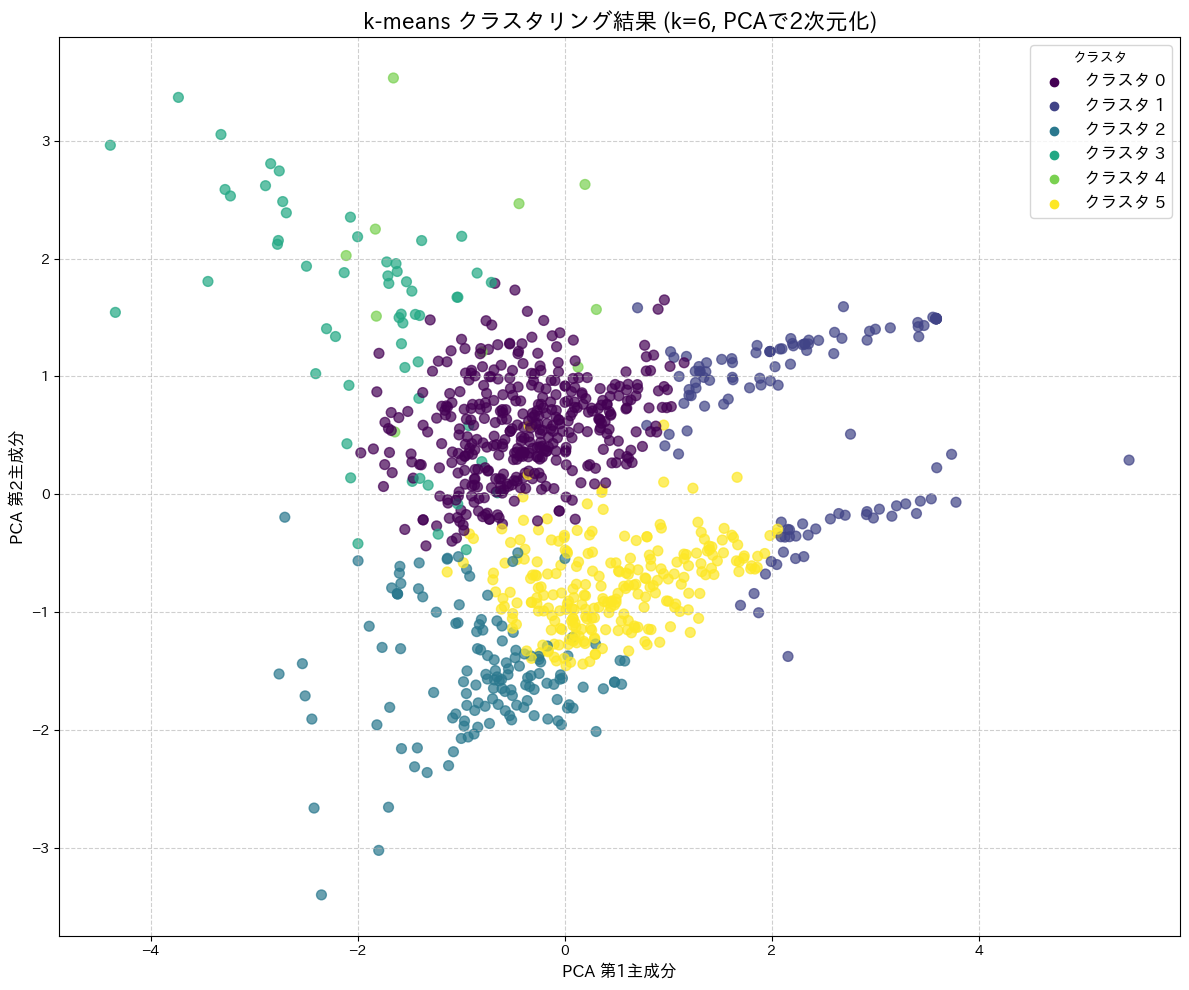

可視化グラフを /home/ubuntu/cabochaProject/4clustering_visualization.png に保存しました。


In [7]:
# ==========================
# セル 7: 結果の可視化
# ==========================
print("--- 結果の可視化と保存 ---")
plt.figure(figsize=(12, 10))
scatter = plt.scatter(features_pca[:, 0], features_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7, s=50)

# 各クラスタの凡例を作成
legend_elements = [plt.scatter([], [], marker='o', color=scatter.cmap(scatter.norm(label)), label=f'クラスタ {label}') 
                   for label in np.unique(cluster_labels)]
plt.legend(handles=legend_elements, title="クラスタ", fontsize=12)

plt.title(f'k-means クラスタリング結果 (k={OPTIMAL_K}, PCAで2次元化)', fontsize=16)
plt.xlabel("PCA 第1主成分", fontsize=12)
plt.ylabel("PCA 第2主成分", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# 画像ファイルとして保存
plt.savefig(OUTPUT_GRAPH_PATH)
plt.show()

print(f"可視化グラフを {OUTPUT_GRAPH_PATH} に保存しました。")

In [9]:
# ====================================
# セル 8: 結果データフレームの作成
# ====================================
print("--- 結果をまとめたデータフレームを作成 ---")

# 結果を格納するデータフレームを作成
df_results = pd.DataFrame({
    '元のテキスト': texts_to_cluster,
    'クラスタラベル': cluster_labels
})

# 生の特徴量
df_raw_features = pd.DataFrame(features_matrix_imputed, columns=[f"raw_{name}" for name in feature_names])
# スケーリング後の特徴量
df_scaled_features = pd.DataFrame(features_scaled, columns=[f"scaled_{name}" for name in feature_names])
# PCA後の特徴量
df_pca_features = pd.DataFrame(features_pca, columns=['PCA1', 'PCA2'])

# 全てのデータフレームを結合
df_final_results = pd.concat([df_results, df_raw_features, df_scaled_features, df_pca_features], axis=1)

# クラスタラベルでソートして表示
df_final_results_sorted = df_final_results.sort_values('クラスタラベル').reset_index(drop=True)

print("データフレーム作成完了。先頭5行を表示します:")
display(df_final_results_sorted.head())

--- 結果をまとめたデータフレームを作成 ---
データフレーム作成完了。先頭5行を表示します:


,元のテキスト,クラスタラベル,raw_熟語編集距離,raw_単語3-gram異常度,raw_Token依存距離分散,raw_係り受けスコア分散,raw_辞書照合,scaled_熟語編集距離,scaled_単語3-gram異常度,scaled_Token依存距離分散,scaled_係り受けスコア分散,scaled_辞書照合,PCA1,PCA2
0,１９９４年 第１３回ロドルフォ・リピツァー賞ヴァイオリン・コンクール１位なしの第４位。,0,0.0,-21.884653,37.778393,0.862215,1.0,-0.286399,0.347387,-0.338839,-0.752024,0.880185,0.689708,0.836581
1,日本のテレビ局による国産テレビアニメへの参入はＴＢＳが１番最初で、１９６１年に『インスタント...,0,0.0,-26.035040,37.062222,1.745976,1.0,-0.286399,-0.737999,-0.345497,0.106066,0.880185,-0.493755,0.294548
2,また、昭和３０年代既に衰退しつつあった国内鉱業について、多数の鉱山・炭坑労働者を抱えて人口が...,0,0.0,-25.327826,190.402740,0.966031,1.0,-0.286399,-0.553052,1.080095,-0.651223,0.880185,-0.645846,1.270042
3,内閣改造は憲法６９条または７０条に定める内閣総辞職とは異なり、内閣総理大臣が改選されないため...,0,0.0,-23.609369,127.817574,1.913877,1.0,-0.286399,-0.103651,0.498246,0.269089,0.880185,-0.560428,0.637832
4,８００年前、オーズドライバーを装着しあらゆるコンボを駆使してグリード封印した人物。,0,0.0,-21.369499,28.547501,0.221920,1.0,-0.286399,0.482107,-0.424658,-1.373720,0.880185,1.154437,1.116504


In [10]:
# ==================================
# セル 9: 学習成果物の保存
# ==================================
print("--- 学習成果物の保存開始 ---")
os.makedirs(ARTIFACTS_OUTPUT_DIR, exist_ok=True)

# 1. モデルの保存
with open(os.path.join(ARTIFACTS_OUTPUT_DIR, 'imputer.pkl'), 'wb') as f:
    pickle.dump(imputer, f)
with open(os.path.join(ARTIFACTS_OUTPUT_DIR, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)
with open(os.path.join(ARTIFACTS_OUTPUT_DIR, 'kmeans_model.pkl'), 'wb') as f:
    pickle.dump(kmeans, f)
with open(os.path.join(ARTIFACTS_OUTPUT_DIR, 'pca_model.pkl'), 'wb') as f:
    pickle.dump(pca, f)
print(f"Imputer, Scaler, KMeans, PCAモデルを {ARTIFACTS_OUTPUT_DIR} に保存しました。")

# 2. N-gramカウントの保存
ngram_counts_to_save = {
    'trigram': trigram_counts,
    'bigram': bigram_counts,
    'vocab_size': total_vocab_size_ngram
}
with open(os.path.join(ARTIFACTS_OUTPUT_DIR, 'ngram_counts.pkl'), 'wb') as f:
    pickle.dump(ngram_counts_to_save, f)
print(f"N-gramカウントデータを {ARTIFACTS_OUTPUT_DIR} に保存しました。")

# 3. 全結果データフレームの保存 (Pickle形式が最も便利)
df_final_results_sorted.to_pickle(os.path.join(ARTIFACTS_OUTPUT_DIR, 'final_results.pkl'))
print(f"全結果を含むデータフレームを {os.path.join(ARTIFACTS_OUTPUT_DIR, 'final_results.pkl')} に保存しました。")

--- 学習成果物の保存開始 ---
Imputer, Scaler, KMeans, PCAモデルを /home/ubuntu/cabochaProject/clustering_artifacts に保存しました。
N-gramカウントデータを /home/ubuntu/cabochaProject/clustering_artifacts に保存しました。
全結果を含むデータフレームを /home/ubuntu/cabochaProject/clustering_artifacts/final_results.pkl に保存しました。


In [11]:
# ==================================
# セル 10: Excelへのサマリー出力
# ==================================
print("--- サマリーをExcelに出力 ---")

# クラスタごとの生特徴量の平均を計算
cluster_feature_means = df_final_results_sorted.groupby('クラスタラベル')[[f"raw_{name}" for name in feature_names]].mean()
cluster_feature_means.index.name = 'クラスタラベル'

try:
    with pd.ExcelWriter(OUTPUT_EXCEL_PATH, engine='openpyxl') as writer:
        # 全てのテキストとクラスタラベル
        df_final_results_sorted[['元のテキスト', 'クラスタラベル']].to_excel(writer, index=False, sheet_name='クラスタリング結果')
        # クラスタごとの特徴量平均
        cluster_feature_means.to_excel(writer, sheet_name='クラスタ別特徴量平均')

    print(f"サマリー結果を {OUTPUT_EXCEL_PATH} に保存しました。")
except Exception as e:
    print(f"Excelへの書き込み中にエラーが発生しました: {e}")

print("\n--- 全ての処理が完了しました ---")

--- サマリーをExcelに出力 ---
サマリー結果を /home/ubuntu/cabochaProject/4clustering_results.xlsx に保存しました。

--- 全ての処理が完了しました ---
